In [1]:
# ===============================
# Core Python Libraries
# ===============================
import os
import pickle
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from scipy.special import expit  # sigmoid

# ===============================
# Data Visualization
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ===============================
# NLP: NLTK & Gensim
# ===============================
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.util import ngrams

# ===============================
# Scikit-learn: Preprocessing, Models, Metrics
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ===============================
# TensorFlow / Keras
# ===============================
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# ===============================
# Transformers (Hugging Face)
# ===============================
from transformers import (
    AutoTokenizer, AutoModel,
    RobertaTokenizer, RobertaModel,
    BertTokenizer, BertForSequenceClassification,
    XLNetTokenizer, XLNetForSequenceClassification
)
import torch
from torch.optim import AdamW

# ===============================
# Custom Modules
# ===============================
from metrics_calculator import MetricsCalculator
MODEL_DIR = "model"
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
import nltk

# Tokenizer
nltk.download('punkt', quiet=True)

# Stopwords
nltk.download('stopwords', quiet=True)

# WordNet for lemmatizer
nltk.download('wordnet', quiet=True)

#  POS tagging for better lemmatization
nltk.download('averaged_perceptron_tagger', quiet=True)


In [4]:
def upload_dataset(file_path):
    """Load the dataset from a CSV file"""
    df = pd.read_csv(file_path,)
    return df

In [5]:
path=r"Dataset/Bitext_Sample_Customer_Service_Training_Dataset.csv"

In [6]:
df= upload_dataset(path)
df

,utterance,intent,category,tags
0,would it be possible to cancel the order I made?,cancel_order,ORDER,BIP
1,cancelling order,cancel_order,ORDER,BK
2,I need assistance canceling the last order I h...,cancel_order,ORDER,B
3,problem with canceling the order I made,cancel_order,ORDER,B
4,I don't know how to cancel the order I made,cancel_order,ORDER,B
...,...,...,...,...
6534,I do not know what I have to do to track the r...,track_refund,REFUND,BE
6535,check refund status,track_refund,REFUND,BK
6536,help me check the refund status,track_refund,REFUND,B
6537,how can I check if there is any updates on my ...,track_refund,REFUND,BIM


In [7]:
def preprocess_data(df, save_path=None, target_cols=None):

    global label_encoders
    label_encoders = {}  # dictionary to hold encoders for each target column

    if save_path and os.path.exists(save_path):
        print(f"Loading existing preprocessed file: {save_path}")
        df = pd.read_csv(save_path)
    else:
        print("Preprocessing data" + (f" and saving to: {save_path}" if save_path else " (no saving)"))
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))

        def clean_text(text):
            text = str(text).lower()
            tokens = word_tokenize(text)
            tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalnum() and t not in stop_words]
            return ' '.join(tokens)

        # Separate target columns
        target_df = None
        if target_cols:
            existing_targets = [col for col in target_cols if col in df.columns]
            target_df = df[existing_targets].copy()
            df = df.drop(columns=existing_targets)

        # Process text columns
        text_columns = df.select_dtypes(include='object').columns
        for col in text_columns:
            df[f'processed_{col}'] = df[col].apply(clean_text)

        # Drop original text columns
        df.drop(columns=text_columns, inplace=True)

        # Reattach target columns
        if target_df is not None:
            for col in target_df.columns:
                df[col] = target_df[col]

        # Save only if path is specified
        if save_path:
            df.to_csv(save_path, index=False)

    # Select processed and numerical columns
    processed_text_cols = [col for col in df.columns if col.startswith('processed_')]
    non_text_cols = [col for col in df.columns if col not in processed_text_cols + (target_cols if target_cols else [])]

    # Join processed text columns into one string
    X_text = df[processed_text_cols].astype(str).agg(' '.join, axis=1)

    # Combine with numerical columns if any
    X_numeric = df[non_text_cols].values if non_text_cols else None
    if X_numeric is not None and len(X_numeric) > 0:
        X = [f"{text} {' '.join(map(str, numeric))}" for text, numeric in zip(X_text, X_numeric)]
    else:
        X = X_text.tolist()

    # Encode multiple target columns
    Y_dict = {}
    if target_cols:
        for col in target_cols:
            if col in df.columns:
                le = LabelEncoder()
                Y_dict[col] = le.fit_transform(df[col])
                label_encoders[col] = le

    return X, Y_dict

In [8]:
X, Y_dict = preprocess_data(df, save_path="cleaned_data.csv", target_cols=["intent","category"])

Loading existing preprocessed file: cleaned_data.csv


In [9]:
labels_vars = {}  # dictionary to hold the labels
label_encoders_original=label_encoders
for i, (col, le) in enumerate(label_encoders.items(), start=1):
    var_name = f"labels{i}"
    labels_vars[var_name] = list(le.classes_)

# Now you can access them like:
labels1 = labels_vars.get("labels1")
labels2 = labels_vars.get("labels2")

print("labels1:", labels1)
print("labels2:", labels2)

metrics1 = MetricsCalculator(labels=labels1,category="intent")
metrics2 = MetricsCalculator(labels=labels2,category="category")


labels1: ['cancel_order', 'change_order', 'change_shipping_address', 'check_cancellation_fee', 'check_invoice', 'check_payment_methods', 'check_refund_policy', 'complaint', 'contact_customer_service', 'contact_human_agent', 'create_account', 'delete_account', 'delivery_options', 'delivery_period', 'edit_account', 'get_invoice', 'get_refund', 'newsletter_subscription', 'payment_issue', 'place_order', 'recover_password', 'registration_problems', 'review', 'set_up_shipping_address', 'switch_account', 'track_order', 'track_refund']
labels2: ['ACCOUNT', 'CANCELLATION_FEE', 'CONTACT', 'DELIVERY', 'FEEDBACK', 'INVOICE', 'NEWSLETTER', 'ORDER', 'PAYMENT', 'REFUND', 'SHIPPING_ADDRESS']


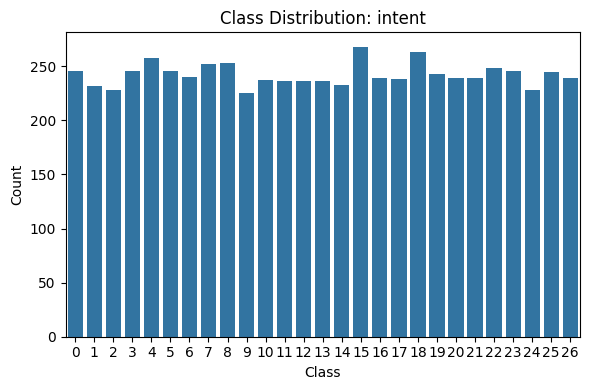

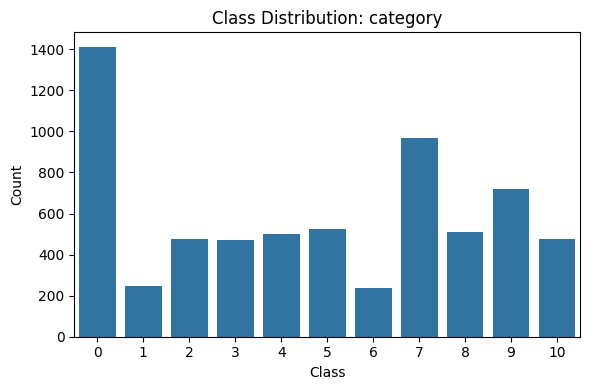

In [10]:
def plot_target_distributions(Y_dict):
    """
    Create count plots for each target column in Y_dict.
    
    Parameters:
        Y_dict (dict): Dictionary where keys are target column names and values are encoded label arrays.
    """
    # Convert to DataFrame for easy plotting
    y_df = pd.DataFrame(Y_dict)

    # Plot each column
    for col in y_df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x=y_df[col])
        plt.title(f'Class Distribution: {col}')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
plot_target_distributions(Y_dict)


In [11]:
def eda_nlp_analysis(X_text, num_words=100, top_n_words=20):
    """
    Perform NLP EDA:
        1. WordCloud
        2. Top N words
        3. Document length histogram
        4. POS tag frequency
        5. Bigram frequency

    Parameters:
        X_text (list of str): Input preprocessed text data.
        num_words (int): Number of words to show in word cloud.
        top_n_words (int): Number of top frequent words to plot.
    """
    print("Generating NLP EDA Visualizations...")

    # Flatten all tokens from all texts
    all_tokens = [word for doc in X_text for word in word_tokenize(doc)]

    # --- 1. WordCloud ---
    word_freq = Counter(all_tokens)
    wc = WordCloud(width=800, height=400, max_words=num_words, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top {num_words} Words - WordCloud")
    plt.show()

    # --- 2. Top-N Frequent Words ---
    common_words = word_freq.most_common(top_n_words)
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(f"Top {top_n_words} Most Frequent Words")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.show()

    # --- 3. Document Length Histogram ---
    doc_lengths = [len(word_tokenize(doc)) for doc in X_text]
    plt.figure(figsize=(10, 5))
    sns.histplot(doc_lengths, bins=20, kde=True, color='teal')
    plt.title("Distribution of Document Lengths (in words)")
    plt.xlabel("Number of Words per Document")
    plt.ylabel("Frequency")
    plt.show()

    # --- 4. POS Tag Frequency ---
    all_pos = [tag for _, tag in pos_tag(all_tokens)]
    pos_counts = Counter(all_pos).most_common()
    pos_tags, pos_freqs = zip(*pos_counts)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(pos_tags), y=list(pos_freqs), palette="coolwarm")
    plt.title("Part of Speech (POS) Tag Frequency")
    plt.xlabel("POS Tag")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

    # --- 5. Bigram Frequency Plot ---
    bigrams = list(ngrams(all_tokens, 2))
    bigram_freq = Counter(bigrams).most_common(top_n_words)
    bigram_labels = [' '.join(b) for b, _ in bigram_freq]
    bigram_counts = [count for _, count in bigram_freq]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=bigram_counts, y=bigram_labels, palette="magma")
    plt.title(f"Top {top_n_words} Bigrams")
    plt.xlabel("Count")
    plt.ylabel("Bigram")
    plt.show()


Generating NLP EDA Visualizations...


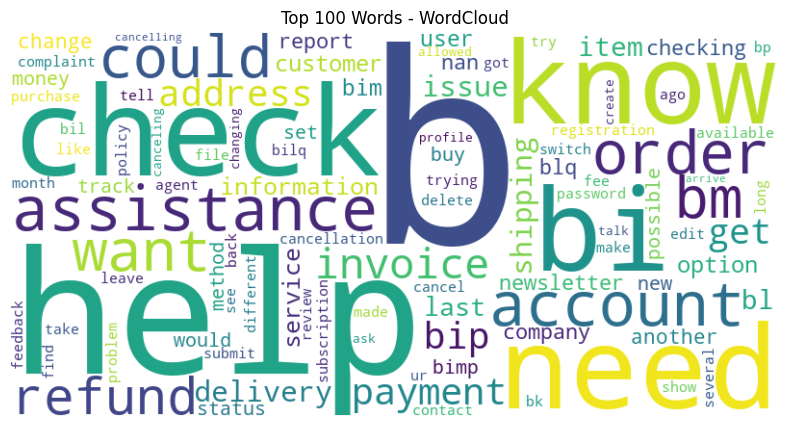

C:\Users\APPLE\AppData\Local\Temp\ipykernel_8948\1063056502.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


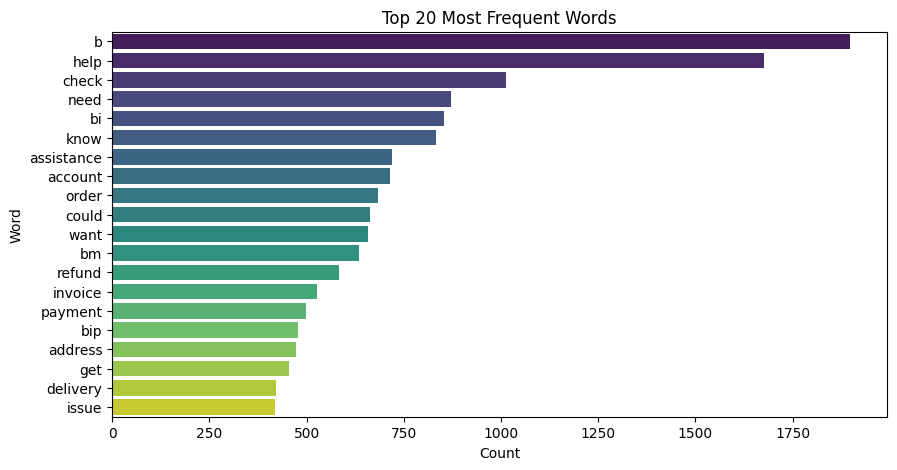

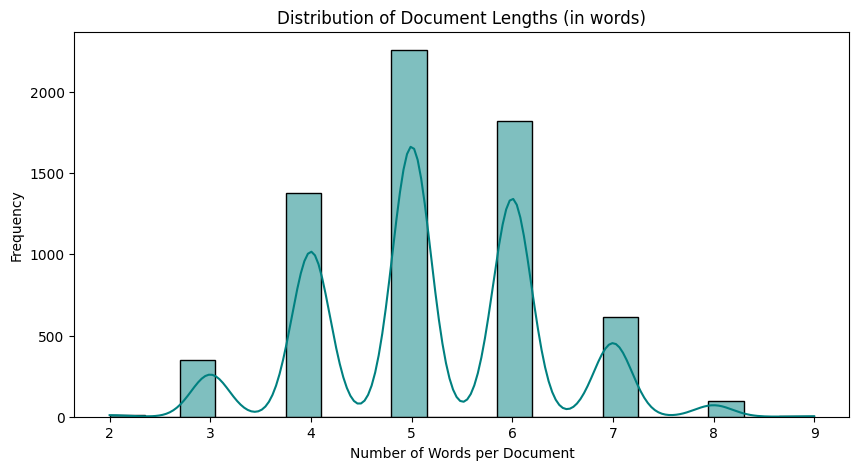

C:\Users\APPLE\AppData\Local\Temp\ipykernel_8948\1063056502.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_tags), y=list(pos_freqs), palette="coolwarm")


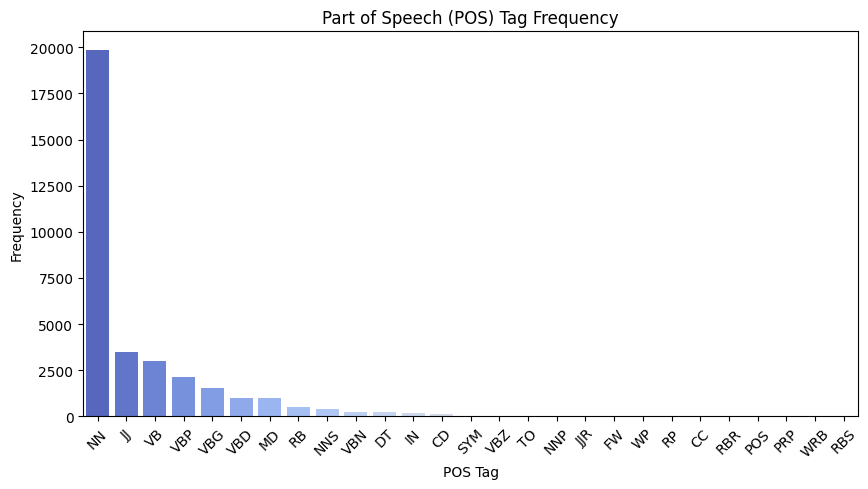

C:\Users\APPLE\AppData\Local\Temp\ipykernel_8948\1063056502.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_counts, y=bigram_labels, palette="magma")


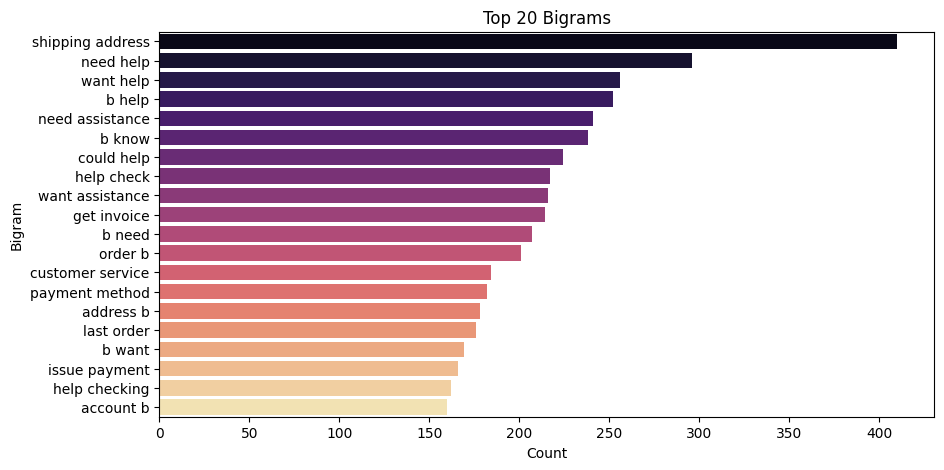

In [12]:
eda_nlp_analysis(X_text=X, num_words=100, top_n_words=20)

In [13]:
from tqdm import tqdm

def minilm_feature_extraction(texts, model_name='microsoft/MiniLM-L12-H384-uncased', batch_size=32, pooling='mean'):
    """Extract MiniLM features from texts with tqdm progress bar."""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()

    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting MiniLM embeddings"):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')

        with torch.no_grad():
            model_output = model(**encoded_input)

        token_embeddings = model_output.last_hidden_state  # [batch_size, seq_len, hidden_dim]
        attention_mask = encoded_input['attention_mask']
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

        if pooling == 'mean':
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
            sum_mask = input_mask_expanded.sum(dim=1)
            embeddings = sum_embeddings / sum_mask
        elif pooling == 'cls':
            embeddings = token_embeddings[:, 0, :]  # CLS token
        else:
            raise ValueError("Pooling must be 'mean' or 'cls'")

        all_embeddings.append(embeddings.cpu().numpy())

    X = np.vstack(all_embeddings)
    return X, model


def feature_extraction(X_text, method='MiniLM_word_embeddings', model_dir='model', is_train=True):
    x_file = os.path.join(model_dir, f'X_{method}.pkl')

    print(f"[INFO] Feature extraction method: {method}, Train mode: {is_train}")
    model_name = 'microsoft/MiniLM-L12-H384-uncased'  
    # alternatives: 'sentence-transformers/all-MiniLM-L6-v2' (smaller, fast for semantic similarity)

    if is_train:
        if os.path.exists(x_file):
            print(f"[INFO] Loading cached MiniLM features from {x_file}")
            X = joblib.load(x_file)
        else:
            print("[INFO] Computing MiniLM features...")
            X, model = minilm_feature_extraction(X_text, model_name=model_name, pooling='mean')
            os.makedirs(model_dir, exist_ok=True)
            joblib.dump(X, x_file)
    else:
        print("[INFO] Performing MiniLM feature extraction for testing...")
        X, model = minilm_feature_extraction(X_text, model_name=model_name, pooling='mean')

    return X


In [14]:
features = feature_extraction(X, method='MiniLM-WE',is_train=True)

[INFO] Feature extraction method: MiniLM-WE, Train mode: True
[INFO] Loading cached MiniLM features from model\X_MiniLM-WE.pkl


In [13]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

features_smoted = {}
labels_smoted = {}

for i, (key, y) in enumerate(Y_dict.items(), start=1):
    X_resampled, y_resampled = smote.fit_resample(features, y)
    features_smoted[f'features{i}'] = X_resampled
    labels_smoted[f'Y{i}'] = y_resampled
    print(f"Balanced '{key}' class: features{i}.shape = {X_resampled.shape}, Y{i}.shape = {y_resampled.shape}")

features_dict = {
    'intent': features_smoted['features1'],
    'category': features_smoted['features2']
}
labels_dict = {
    'intent': labels_smoted['Y1'],
    'category': labels_smoted['Y2']
}

Balanced 'intent' class: features1.shape = (7236, 384), Y1.shape = (7236,)
Balanced 'category' class: features2.shape = (15532, 384), Y2.shape = (15532,)


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

def train_single_ml_model(Algorithm_prefix, features_dict, Y_dict, algorithm):
    global metrics1,metrics2

    ml_models = {}

    # Mapping of algorithm names to model classes
    model_mapping = {
        "DTC": DecisionTreeClassifier,
        "KNN": KNeighborsClassifier,
        "NBC": GaussianNB
    }

    if algorithm not in model_mapping:
        raise ValueError(f"Unknown algorithm: {algorithm}")

    for target_name, y_encoded in Y_dict.items():
        X = features_dict[target_name]
        model_instance = model_mapping[algorithm]()
        model_path = f"model/{Algorithm_prefix}_{target_name}_{algorithm}_model.pkl"
        algo_name = f"{algorithm}"

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        if os.path.exists(model_path):
            print(f"Loading existing {algorithm} model for {target_name}...")
            mdl = joblib.load(model_path)
        else:
            print(f"Training {algorithm} for target: {target_name}...")
            mdl = model_instance
            mdl.fit(X_train, y_train)
            joblib.dump(mdl, model_path)

        y_pred = mdl.predict(X_test)
        try:
            y_score = mdl.predict_proba(X_test)
        except AttributeError:
            y_score = None

        # Metrics calculation
        if target_name == "intent":
            metrics1.calculate_metrics(algo_name, y_pred, y_test, y_score)
        elif target_name == "category":
            metrics2.calculate_metrics(algo_name, y_pred, y_test, y_score)
        else:
            print("No classifier found")
        ml_models[f"{target_name}_{algorithm}"] = mdl

    return ml_models

In [15]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

# Train the model (no warnings will be shown)
models = train_single_ml_model("MiniLM-WE", features_dict, labels_dict, "DTC")

Loading existing DTC model for intent...
DTC Accuracy  : 76.24
DTC Precision : 76.37
DTC Recall    : 76.26
DTC FScore    : 76.17
DTC Classification Report
DTC
                          precision    recall  f1-score   support

            cancel_order       0.72      0.77      0.75        53
            change_order       0.77      0.74      0.75        54
 change_shipping_address       0.71      0.69      0.70        54
  check_cancellation_fee       0.67      0.61      0.64        54
           check_invoice       0.85      0.76      0.80        54
   check_payment_methods       0.67      0.69      0.68        54
     check_refund_policy       0.81      0.89      0.85        54
               complaint       0.61      0.65      0.63        54
contact_customer_service       0.82      0.92      0.87        53
     contact_human_agent       0.81      0.74      0.77        53
          create_account       0.58      0.56      0.57        54
          delete_account       0.78      0.85   

In [16]:
models = train_single_ml_model("MiniLM-WE", features_dict, labels_dict, "NBC")

Loading existing NBC model for intent...
NBC Accuracy  : 88.33
NBC Precision : 88.92
NBC Recall    : 88.35
NBC FScore    : 88.44
NBC Classification Report
NBC
                          precision    recall  f1-score   support

            cancel_order       0.98      0.91      0.94        53
            change_order       0.94      0.87      0.90        54
 change_shipping_address       0.88      0.80      0.83        54
  check_cancellation_fee       0.98      0.91      0.94        54
           check_invoice       0.98      0.93      0.95        54
   check_payment_methods       1.00      0.91      0.95        54
     check_refund_policy       0.88      0.81      0.85        54
               complaint       0.77      0.87      0.82        54
contact_customer_service       1.00      0.96      0.98        53
     contact_human_agent       0.88      0.96      0.92        53
          create_account       0.61      0.61      0.61        54
          delete_account       0.96      0.85   

In [17]:
models = train_single_ml_model("MiniLM-WE", features_dict, labels_dict, "KNN")

Loading existing KNN model for intent...
KNN Accuracy  : 91.64
KNN Precision : 91.92
KNN Recall    : 91.65
KNN FScore    : 91.63
KNN Classification Report
KNN
                          precision    recall  f1-score   support

            cancel_order       0.93      0.94      0.93        53
            change_order       0.98      0.83      0.90        54
 change_shipping_address       0.92      0.89      0.91        54
  check_cancellation_fee       0.81      0.87      0.84        54
           check_invoice       0.90      0.87      0.89        54
   check_payment_methods       0.90      0.96      0.93        54
     check_refund_policy       0.96      0.93      0.94        54
               complaint       0.90      0.83      0.87        54
contact_customer_service       1.00      0.96      0.98        53
     contact_human_agent       1.00      0.94      0.97        53
          create_account       0.82      0.85      0.84        54
          delete_account       0.92      0.87   

In [18]:
def plot_training_history(history, title=None):
    """Plot training and validation accuracy/loss."""
    if history is None or not isinstance(history, dict):
        print("[ERROR] Invalid history format.")
        return

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    if 'accuracy' in history:
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Acc')
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], label='Val Acc')
        plt.title(f"{title} Accuracy" if title else "Accuracy")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    # Loss Plot
    if 'loss' in history:
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Val Loss')
        plt.title(f"{title} Loss" if title else "Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()
def plot_all_histories_from_folder(folder_path="model"):
    """Automatically read and plot all *_history.npy files in a folder."""
    history_files = [f for f in os.listdir(folder_path) if f.endswith("_history.npy")]

    if  history_files:
        print(history_files)

    for file in history_files:
        full_path = os.path.join(folder_path, file)
        try:
            history = np.load(full_path, allow_pickle=True).item()
            plot_training_history(history, title=file.replace("_history.npy", ""))
        except Exception as e:
            print(f"[ERROR] Could not load {file}: {e}")


In [19]:
def train_feature_selector(features_dict, labels_dict, model_prefix="SBERT"):
    extracted_features_dict = {}

    for target_name, y in labels_dict.items():
        X = features_dict[target_name]
        
        # File paths for each target
        model_path = f"model/{model_prefix}_{target_name}_dense_model.h5"
        feature_path = f"model/{model_prefix}_{target_name}_features.npy"
        history_path = f"model/{model_prefix}_{target_name}_history.npy"

        if all(os.path.exists(p) for p in [model_path, feature_path, history_path]):
            print(f"✅ [LOAD] {target_name}: Model and features found. Loading...")
            model = load_model(model_path)
            features = np.load(feature_path)
            extracted_features_dict[target_name] = features
            continue

        print(f"🚀 [TRAIN] {target_name}: No saved model found. Training new Dense model...")

        num_classes = len(np.unique(y))
        y_categorical = to_categorical(y, num_classes=num_classes)

        input_layer = Input(shape=(X.shape[1],))
        x = Dense(512, activation='relu')(input_layer)
        x = Dense(256, activation='relu')(x)
        x = Dense(128, activation='relu', name='feature_layer')(x)
        x = Dense(64, activation='relu')(x)
        output_layer = Dense(num_classes, activation='softmax')(x)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            X, y_categorical,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=1
        )

        # Extract features from mid-layer
        feature_extractor = Model(inputs=model.input, outputs=model.get_layer('feature_layer').output)
        features = feature_extractor.predict(X)

        # Save results
        model.save(model_path)
        np.save(feature_path, features)
        np.save(history_path, history.history)

        print(f"💾 [SAVED] {target_name}: Model, features, and training history saved.")
        extracted_features_dict[target_name] = features

    return extracted_features_dict

In [20]:
extracted_features_dict = train_feature_selector(features_dict, labels_dict, model_prefix="MiniLM-WE DNN")

✅ [LOAD] intent: Model and features found. Loading...


✅ [LOAD] category: Model and features found. Loading...


['MiniLM-WE DNN_category_history.npy', 'MiniLM-WE DNN_intent_history.npy']


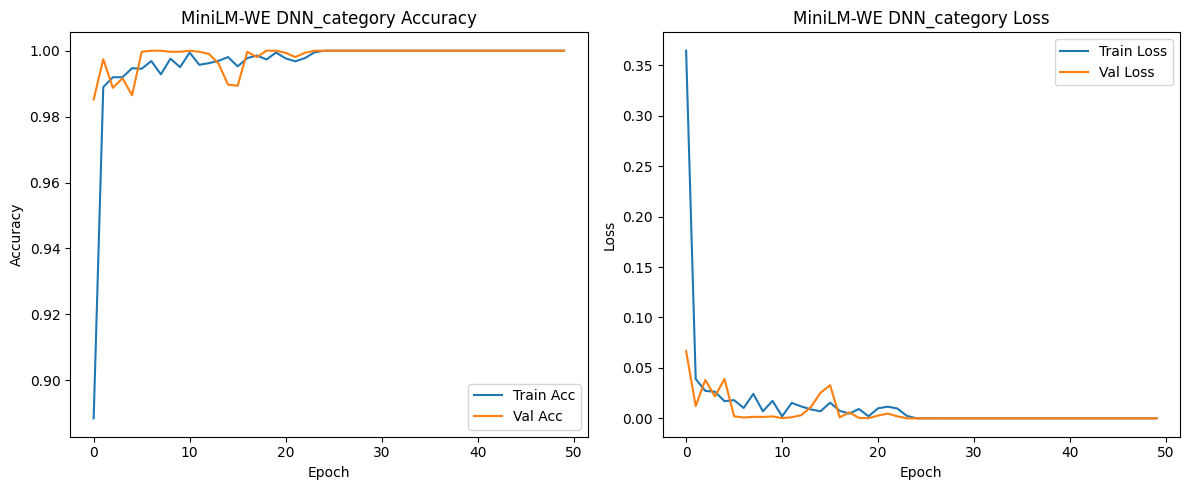

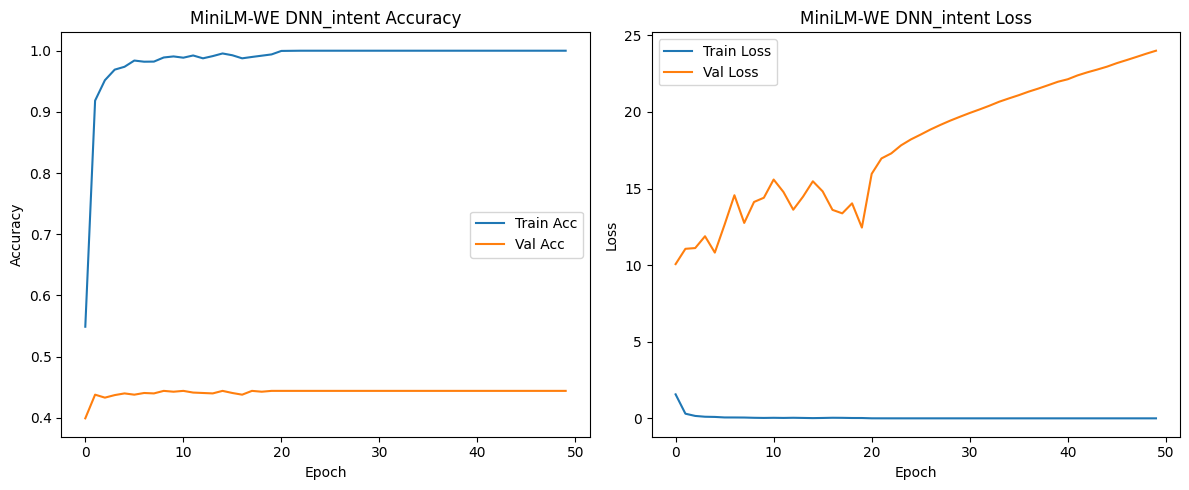

In [21]:
plot_all_histories_from_folder("model")

In [22]:
def train_multioutput_knn(Algorithm_prefix, features_dict, labels_dict):
    model_results = {}
    global metrics1,metrics2
    for target_name, y_encoded in labels_dict.items():
        X = features_dict[target_name]
        model_path = f"model/{Algorithm_prefix}_{target_name}_KNN_model.pkl"
        algo_name = f"{Algorithm_prefix} KNN"

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        if os.path.exists(model_path):
            print(f"Loading existing KNN model for {target_name}...")
            model = joblib.load(model_path)
        else:
            print(f"Training KNN for target: {target_name}...")
            model = KNeighborsClassifier()
            model.fit(X_train, y_train)
            joblib.dump(model, model_path)

        y_pred = model.predict(X_test)

        try:
            y_score = model.predict_proba(X_test)
        except AttributeError:
            y_score = None

        # Metrics calculation
        # Metrics calculation
        if target_name == "intent":
            metrics1.calculate_metrics(algo_name, y_pred, y_test, y_score)
        elif target_name == "category":
            metrics2.calculate_metrics(algo_name, y_pred, y_test, y_score)
        else:
            print("No classifier found")

        model_results[target_name] = model

    return model_results

In [23]:
Final_models = train_multioutput_knn("MiniLM-WE DNN", extracted_features_dict, labels_dict)

Loading existing KNN model for intent...
MiniLM-WE DNN KNN Accuracy  : 98.76
MiniLM-WE DNN KNN Precision : 98.76
MiniLM-WE DNN KNN Recall    : 98.75
MiniLM-WE DNN KNN FScore    : 98.75
MiniLM-WE DNN KNN Classification Report
MiniLM-WE DNN KNN
                          precision    recall  f1-score   support

            cancel_order       1.00      0.98      0.99        53
            change_order       0.96      1.00      0.98        54
 change_shipping_address       1.00      1.00      1.00        54
  check_cancellation_fee       1.00      1.00      1.00        54
           check_invoice       1.00      1.00      1.00        54
   check_payment_methods       1.00      1.00      1.00        54
     check_refund_policy       1.00      0.96      0.98        54
               complaint       0.98      1.00      0.99        54
contact_customer_service       1.00      1.00      1.00        53
     contact_human_agent       0.98      1.00      0.99        53
          create_account      

In [24]:
results_df = metrics1.overall_classifiers_comparision()

In [25]:
results_df

Metric,Accuracy,F1-Score,Precision,Recall
Algorithm,,,,
DTC,76.243094,76.173960,76.365932,76.257215
NBC,88.328729,88.444405,88.920409,88.353133
KNN,91.643646,91.630849,91.922022,91.645314
MiniLM-WE DNN KNN,98.756906,98.745737,98.756477,98.751197


In [26]:
results_df1 = metrics1.class_specific_classifiers_comparision()

In [27]:
results_df1

,Label,Algorithm,Precision,Recall,F1-Score,Support
0,cancel_order,DTC,71.929825,77.358491,74.545455,53.0
1,cancel_order,KNN,92.592593,94.339623,93.457944,53.0
2,cancel_order,MiniLM-WE DNN KNN,100.000000,98.113208,99.047619,53.0
3,cancel_order,NBC,97.959184,90.566038,94.117647,53.0
4,change_order,DTC,76.923077,74.074074,75.471698,54.0
...,...,...,...,...,...,...
103,track_order,NBC,92.857143,96.296296,94.545455,54.0
104,track_refund,DTC,91.836735,83.333333,87.378641,54.0
105,track_refund,KNN,91.228070,96.296296,93.693694,54.0
106,track_refund,MiniLM-WE DNN KNN,96.428571,100.000000,98.181818,54.0


In [28]:
results_df2 = metrics2.overall_classifiers_comparision()

In [29]:
results_df2

Metric,Accuracy,F1-Score,Precision,Recall
Algorithm,,,,
NBC,90.794979,90.873915,91.152892,90.797457
DTC,91.728355,91.622548,91.633599,91.726983
KNN,97.328613,97.246195,97.409272,97.326585
MiniLM-WE DNN KNN,100.000000,100.000000,100.000000,100.000000


In [30]:
results_df3 = metrics2.class_specific_classifiers_comparision()
results_df3

,Label,Algorithm,Precision,Recall,F1-Score,Support
0,ACCOUNT,DTC,80.497925,68.794326,74.187380,282.0
1,ACCOUNT,KNN,97.807018,79.078014,87.450980,282.0
2,ACCOUNT,MiniLM-WE DNN KNN,100.000000,100.000000,100.000000,282.0
3,ACCOUNT,NBC,71.612903,78.723404,75.000000,282.0
4,CANCELLATION_FEE,DTC,93.150685,96.453901,94.773519,282.0
5,CANCELLATION_FEE,KNN,92.459016,100.000000,96.081772,282.0
6,CANCELLATION_FEE,MiniLM-WE DNN KNN,100.000000,100.000000,100.000000,282.0
7,CANCELLATION_FEE,NBC,96.057348,95.035461,95.543672,282.0
8,CONTACT,DTC,93.906810,92.907801,93.404635,282.0
9,CONTACT,KNN,99.290780,99.290780,99.290780,282.0


In [53]:
def test_DNN_feature_selector(features_test, model_base_name="MiniLM-WE DNN", model_dir="model"):
    feature_outputs = {}
    targets =["intent","category"]

    for target in targets:
        model_filename = f"{model_base_name}_{target}_dense_model.h5"
        model_path = os.path.join(model_dir, model_filename)

        if not os.path.exists(model_path):
            print(f"❌ Model not found: {model_path}")
            continue

        print(f"✅ Loading model for {target}: {model_path}")
        model = load_model(model_path)

        try:
            feature_extractor = Model(inputs=model.input,
                                      outputs=model.get_layer("feature_layer").output)
        except:
            raise ValueError(f"Model does not contain a layer named 'feature_layer': {model_path}")

        print(f"🚀 Extracting features for {target}...")
        extracted_features = feature_extractor.predict(features_test)
        feature_outputs[target] = extracted_features

    return feature_outputs

In [60]:
test_path=r"Dataset/Bitext_Sample_Customer_Service_Testing_Dataset.csv"

In [61]:
df_test1= upload_dataset(test_path)
df_test1
# Initialize result DataFrame
df_result = df_test1.copy()


In [62]:
df_test,_ = preprocess_data(df_test1)

Preprocessing data (no saving)


In [63]:
features_test = feature_extraction(df_test,method='MiniLM-WE',is_train=False)

[INFO] Feature extraction method: MiniLM-WE, Train mode: False
[INFO] Performing MiniLM feature extraction for testing...


Extracting MiniLM embeddings: 100%|████████████████████████████████████████████████████| 26/26 [00:06<00:00,  4.10it/s]


In [64]:
feature_outputs_dict = test_DNN_feature_selector(features_test)

✅ Loading model for intent: model\MiniLM-WE DNN_intent_dense_model.h5
🚀 Extracting features for intent...
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✅ Loading model for category: model\MiniLM-WE DNN_category_dense_model.h5


🚀 Extracting features for category...
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [66]:
# Loop over each target
for target in ["intent","category"]:
    # Get extracted features for current target
    target_features = feature_outputs_dict[target]

    # Predict using the model
    y_pred = Final_models[target].predict(target_features)

    le = label_encoders_original[target]  # Get the label encoder for the current target
    mapped_labels = le.inverse_transform(y_pred)  # Convert numeric labels back to original labels

    # Add prediction column
    df_result[f'Predicted_{target}'] = mapped_labels

# Final output
df_result


,utterance,tags,Predicted_intent,Predicted_category
0,I have a question about cancelling an order,B,cancel_order,ORDER
1,help canceling the order I have made,B,cancel_order,ORDER
2,I do not know how to cancel an order I have made,BE,cancel_order,ORDER
3,where can I cancel the last order I made?,BI,cancel_order,ORDER
4,I don't want the last order I made,B,track_order,ORDER
...,...,...,...,...
813,I am trying to check the status of my refund,B,track_refund,REFUND
814,help checking the refund status,B,track_refund,REFUND
815,will you show me my refund status?,BIP,track_refund,REFUND
816,help to track the refund,B,track_refund,REFUND
